# Advanced Navigation Functionality

##### Last Updated: October 31, 2022

In the previous example we have learned navigation meshes and how we can use them to calculate distances between positions.
In this notebook we will go a bit further and utilize those basic functionality to calculate a distance between
game states and trajectories and visualize multiple rounds at once.

### Generating a distance matrix

As we will be calculating a lot of distances in this example we do not want to call `area_distance(map_name="de_dust2", area_a=152, area_b=8970, dist_type="graph")` every single time that we need the distance between tile `152` and tile `8970`.
Instead we will start off by generating distance matrices that contain the distance for every pair of tiles.
Alternatively you can download examples from [here](https://cernbox.cern.ch/files/public/show/T1BJ69qKLlK1fSu).
Note however that these matrices will change whenever a map update changes the navigation mesh. Once you have them downloaded they are all available in `awpy.data.AREA_DIST_MATRIX`

In [1]:
from awpy.analytics.nav import generate_area_distance_matrix
from awpy.data import AREA_DIST_MATRIX
import itertools

Lets now try to get the matrix for de_ancient. If you calculate this for the first time it will take roughly 30 minute.

In [2]:
if "de_ancient" in AREA_DIST_MATRIX:
    ancient_area_distance_matrix = AREA_DIST_MATRIX["de_ancient"]
else:
    ancient_area_distance_matrix = generate_area_distance_matrix(map_name="de_ancient", save=False)
{k:v for k, v in list(ancient_area_distance_matrix["777"].items())[:10]}

{'777': {'euclidean': 0.0, 'graph': 0, 'geodesic': 0},
 '2498': {'euclidean': 2188.1323225327505,
  'graph': 32,
  'geodesic': 3752.8812720181772},
 '2604': {'euclidean': 1854.5402180374672,
  'graph': 34,
  'geodesic': 3528.828616993278},
 '3141': {'euclidean': 1874.4808256402948,
  'graph': 32,
  'geodesic': 3631.378323126444},
 '525': {'euclidean': 1451.025292635863,
  'graph': 32,
  'geodesic': 3252.6546431938873},
 '1878': {'euclidean': 1266.3022845171029,
  'graph': 29,
  'geodesic': 2716.2248777587324},
 '2489': {'euclidean': 1483.7472999808863,
  'graph': 32,
  'geodesic': 3089.8824205885803},
 '2777': {'euclidean': 1272.9615197318535,
  'graph': 28,
  'geodesic': 2870.030243057318},
 '3144': {'euclidean': 2013.9065459971375,
  'graph': 32,
  'geodesic': 3623.564420090066},
 '1745': {'euclidean': 1635.9983189836967,
  'graph': 32,
  'geodesic': 3404.162133375803}}

This is the first row in our distance matrix. We see that for every possible target it contains three distances.
One calculated by the simple euclidean distance between the centers of the two tiles and then the two navigation mesh based
ones from last example.
As expected we see that the distance from the tile to itself is zero.

On other maps same entries may be infinite because there is no direct connection from your source tile to the target, that the game knows of. One example for that is the Silo on de_nuke. You can not get there from any other area because the game does not account for the jump up. The distance from the Silo to other places however is finite as the game knows you can drop down from there.

In [3]:
if "de_nuke" in AREA_DIST_MATRIX:
    nuke_area_distance_matrix = AREA_DIST_MATRIX["de_nuke"]
else:
    nuke_area_distance_matrix = generate_area_distance_matrix(map_name="de_nuke", save=False)

In [4]:
nuke_area_distance_matrix["639"]["839"]["geodesic"]

inf

In [5]:
nuke_area_distance_matrix["839"]["639"]["geodesic"]

2624.9892872412574

# Assigning distances to game states
Next we will make use of this distance matrix to determine distances between game states.
Lets start out by looking at a couple a couple of frames from one of my faceit games.
If you want you can download them from my [cernbox](https://cernbox.cern.ch/s/GKmMFoSqMYbZPvt) alongside all other resources needed to run this notebook.

Lets load the json file and define some useful functions and variables for later.

In [6]:
import json
from awpy.visualization.plot import plot_positions, position_transform
with open("703.json", encoding="utf-8") as f:
    ancient_game = json.load(f)
frames = [ancient_game["gameRounds"][5]["frames"][6+i] for i in range(2)]

In [7]:
colorlist = ["red", "green", "white", "gold", "black"]
def plot_players_id(frames, steamids, colorlist):
    positions = []
    colors = []
    markers = []
    for i, f in enumerate(frames):
        for side in ["t"]:
            for p in f[side]["players"]:
                markers.append(rf"$ {i} $")
                colors.append(colorlist[steamids.index(p["steamID"])])
                pos = (
                    position_transform("de_ancient", p["x"], "x"),
                    position_transform("de_ancient", p["y"], "y"),
                )
                positions.append(pos)
    plot_positions(  positions=positions,
                colors=colors,
                markers=markers,
                map_name="de_ancient")
steamids = sorted([player["steamID"] for player in frames[0]["t"]["players"]])

def plot_players_mapping(frames, steamids, colorlist, mapping):
    positions = []
    colors = []
    markers = []
    for i, f in enumerate(frames):
        for side in ["t"]:
            for p in f[side]["players"]:
                index = steamids.index(p["steamID"])
                if index > 2.5:
                    continue
                markers.append(rf"$ {i} $")
                if i == 0:
                    colors.append(colorlist[index])
                else:
                    colors.append(colorlist[mapping[index]])
                pos = (
                    position_transform("de_ancient", p["x"], "x"),
                    position_transform("de_ancient", p["y"], "y"),
                )
                positions.append(pos)
    plot_positions(  positions=positions,
                colors=colors,
                markers=markers,
                map_name="de_ancient")
def get_state_distance(frames, steamids, mapping):
    dist = 0
    for i, player in enumerate(frames[0]["t"]["players"]):
        index = steamids.index(player["steamID"])
        if index > 2.5:
            continue
        pos = [player["x"],player["y"],player["z"]]
        for k, player2 in enumerate(frames[1]["t"]["players"]):
            index2 = steamids.index(player2["steamID"])
            if index2 > 2.5:
                continue
            pos2 = [player2["x"],player2["y"],player2["z"]]
            if index == mapping[index2]:
                dist += min(point_distance("de_ancient",pos,pos2,"geodesic")["distance"],point_distance("de_ancient",pos2,pos,"geodesic")["distance"])
    return dist

Now lets have a look at two game states between which we might want to calculate a distance.

(<Figure size 640x480 with 1 Axes>, <AxesSubplot:>)

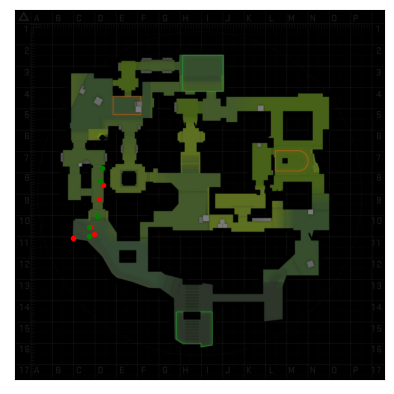

In [8]:
positions = []
colors = []
markers = []
for i, f in enumerate(frames):
    for side in ["t"]:
        for p in f[side]["players"]:
            if p["hp"] == 0:
                markers.append("x")
            else:
                markers.append(".")
            colors.append(colorlist[i])
            pos = (
                position_transform("de_ancient", p["x"], "x"),
                position_transform("de_ancient", p["y"], "y"),
            )
            positions.append(pos)
plot_positions(positions=positions,colors=colors,markers=markers,map_name="de_ancient")

Here we have the positions of all 5 T players in the 6th round in the 7th frame in red and the 8th frame in green.
The easiest way to calculate a distance between these game states is to just take the distances between a players position in the first frame and the second frame and sum them up or average them.

In [9]:
from awpy.analytics.nav import point_distance
dist = 0
for i, player in enumerate(frames[0]["t"]["players"]):
    pos = [player["x"],player["y"],player["z"]]
    for k, player2 in enumerate(frames[1]["t"]["players"]):
        pos2 = [player2["x"],player2["y"],player2["z"]]
        if player["steamID"] == player2["steamID"]:
            dist += min(point_distance("de_ancient",pos,pos2,"geodesic")["distance"],point_distance("de_ancient",pos2,pos,"geodesic")["distance"])
dist

788.6719241288283

This would be equivalent to the following mapping

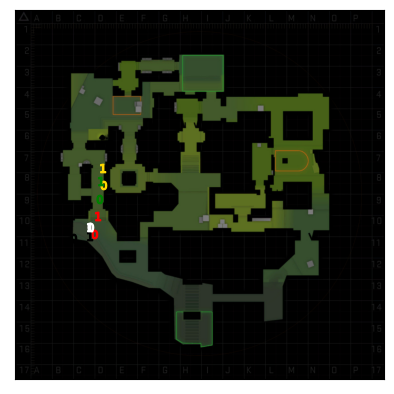

In [10]:
plot_players_id(frames,steamids,colorlist)

Here the color represents the player and the number tells you from which frame they are.

This works fine if you look at frames that are in the same round and close to each other.
However if if you look at frames from different rounds it can become suboptimal and it totally breaks if you have different games with different players entirely.

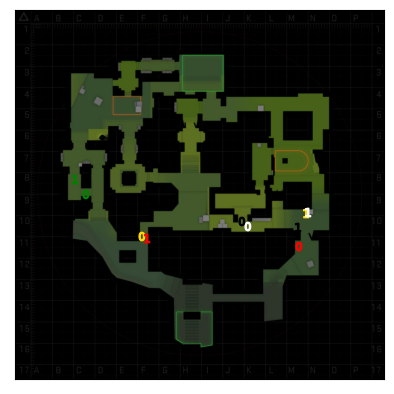

In [11]:
frames = [ancient_game["gameRounds"][6+i]["frames"][6] for i in range(2)]
plot_players_id(frames,steamids,colorlist)

Here it seems intuitive that we might want to group the yellow 0 with the red 1 at the entrance of mid. A different way to assign them compared to their steamid might be useful. So lets just try out all of them for a smaller example and see which might make more sense.

In [12]:
import itertools
mappings = list(itertools.permutations(range(3)))

4239.868035184941

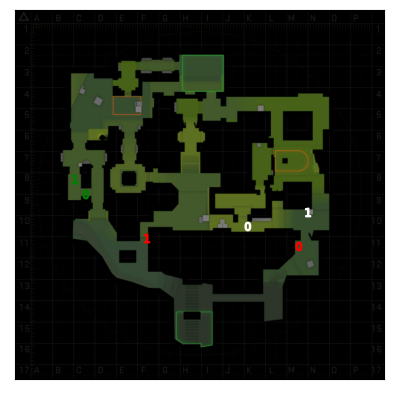

In [13]:
plot_players_mapping(frames,steamids,colorlist,mappings[0])
get_state_distance(frames,steamids,mappings[0])

10653.416592023039

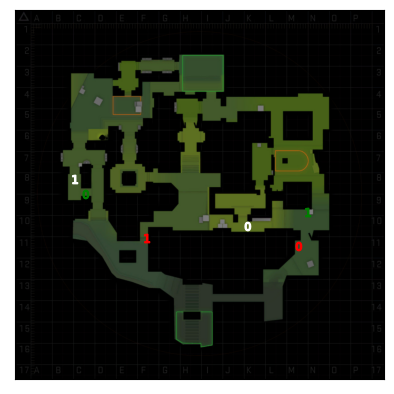

In [14]:
plot_players_mapping(frames,steamids,colorlist,mappings[1])
get_state_distance(frames,steamids,mappings[1])

7096.731223195087

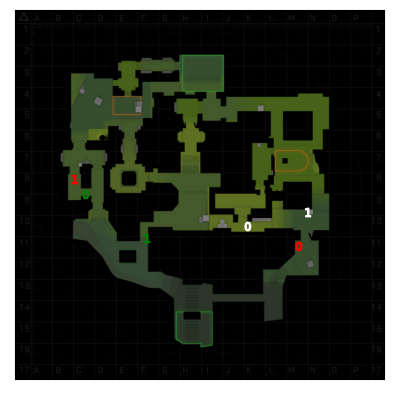

In [15]:
plot_players_mapping(frames,steamids,colorlist,mappings[2])
get_state_distance(frames,steamids,mappings[2])

5660.995932135489

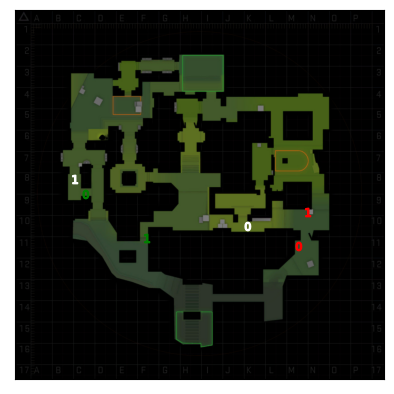

In [16]:
plot_players_mapping(frames,steamids,colorlist,mappings[3])
get_state_distance(frames,steamids,mappings[3])

10653.41659202304

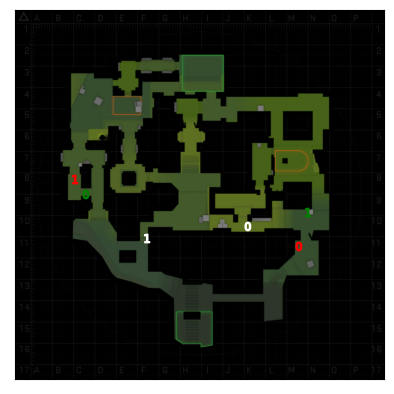

In [17]:
plot_players_mapping(frames,steamids,colorlist,mappings[4])
get_state_distance(frames,steamids,mappings[4])

2804.1327441253434

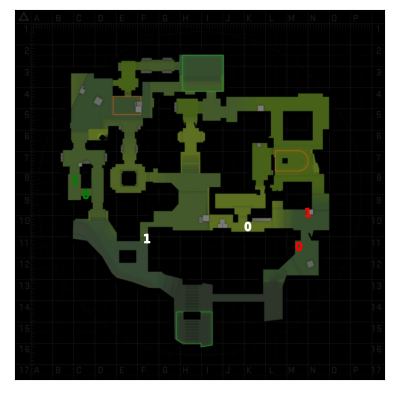

In [18]:
plot_players_mapping(frames,steamids,colorlist,mappings[5])
get_state_distance(frames,steamids,mappings[5])

Here we have all the 6 possible mappings for 3 players. At the top is the calculated distance and at the bottom is the mapping visualized. Intuitively i would say the last one is the best. It also happens to be the one with the smallest total distance.
From now on i will always use this lowest distance mapping to determine the game state distance.

From this we can even straightforwardly define a distance between whole rounds. We just calculate the game state distance at every point and sum them or average them. Alternatively we can do dynamic time warping which i will not discuss here.

### Doing analysis with state distances
One type of analysis one can do with these distances is clustering.
We take multiple game rounds and determine which of these are similar to seach other.
For this i will use an input file of trajectories that was generated from CSGO demos that have been parsed by awpy.
It has been cleaned of all information that is not needed for this analysis and dealt with already assigning players from frame to frame by steamID, handling players leaving mid round, bots and other peculiarities.
The file generated via [this script](https://github.com/JanEricNitschke/csgoml/blob/main/csgoml/scripts/trajectory_input_preparation.py) from the [csgoml](https://github.com/JanEricNitschke/csgoml) library and can also be found in the cernbox link above.
We will also use that library to read the file back in and to prepare it for the clustering.

In [19]:
from csgoml.trajectories import trajectory_handler, trajectory_clusterer
from IPython.display import Image

We will start off by setting up the classes that will do the file handling and final cleaning

In [20]:
handler = trajectory_handler.TrajectoryHandler(
    json_path="Prepared_Input_Tensorflow_ancient.json", random_state=123, map_name="de_ancient"
)

clusterer = trajectory_clusterer.TrajectoryClusterer(
    analysis_path="analysis_path",
    trajectory_handler=handler,
    random_state=123,
    map_name="de_ancient",
)

Next we will set the configuration that we want to use for the clustering.

In [21]:
traj_config = ("area", 10, 10, "T", False)

We will use each players navigation mesh tile for their position and the geodesic distance to determine the game state distances. We will only look at a total of 10 rounds and only consider the first 10 seconds each. We will also not do dynamic time warping.

Next we set up the configuration that we want to use for the clustering itself.

In [22]:
clust_config = {
        "do_histogram": False,
        "n_bins": 1,
        "do_knn": False,
        "knn_ks": [],
        "plot_all_trajectories": True,
        "do_dbscan": True,
        "dbscan_eps": 500,
        "dbscan_minpt": 2,
        "do_kmed": True,
        "kmed_n_clusters": 3,
}

We want to produce a picture that contains all trajectories so that we can look how the clustering split this up in the end.
We will also try two different clustering algorithms. Namely dbscan which is a density based clustering algorithm which is useful when you do not know the numbers of clusters you have. However it is hard but very important to correctly set its two parameters.
Additionally we will use k-medoids clustering which is a generalization of k-means clustering that also works if we do not have a simply euclidean distance.

In [23]:
clusterer.do_clustering(
            trajectory_config=traj_config, clustering_config=clust_config
        )

100%|██████████| 4/4 [00:00<00:00, 399.91it/s]


True

First lets have a look at all of the rounds in one image

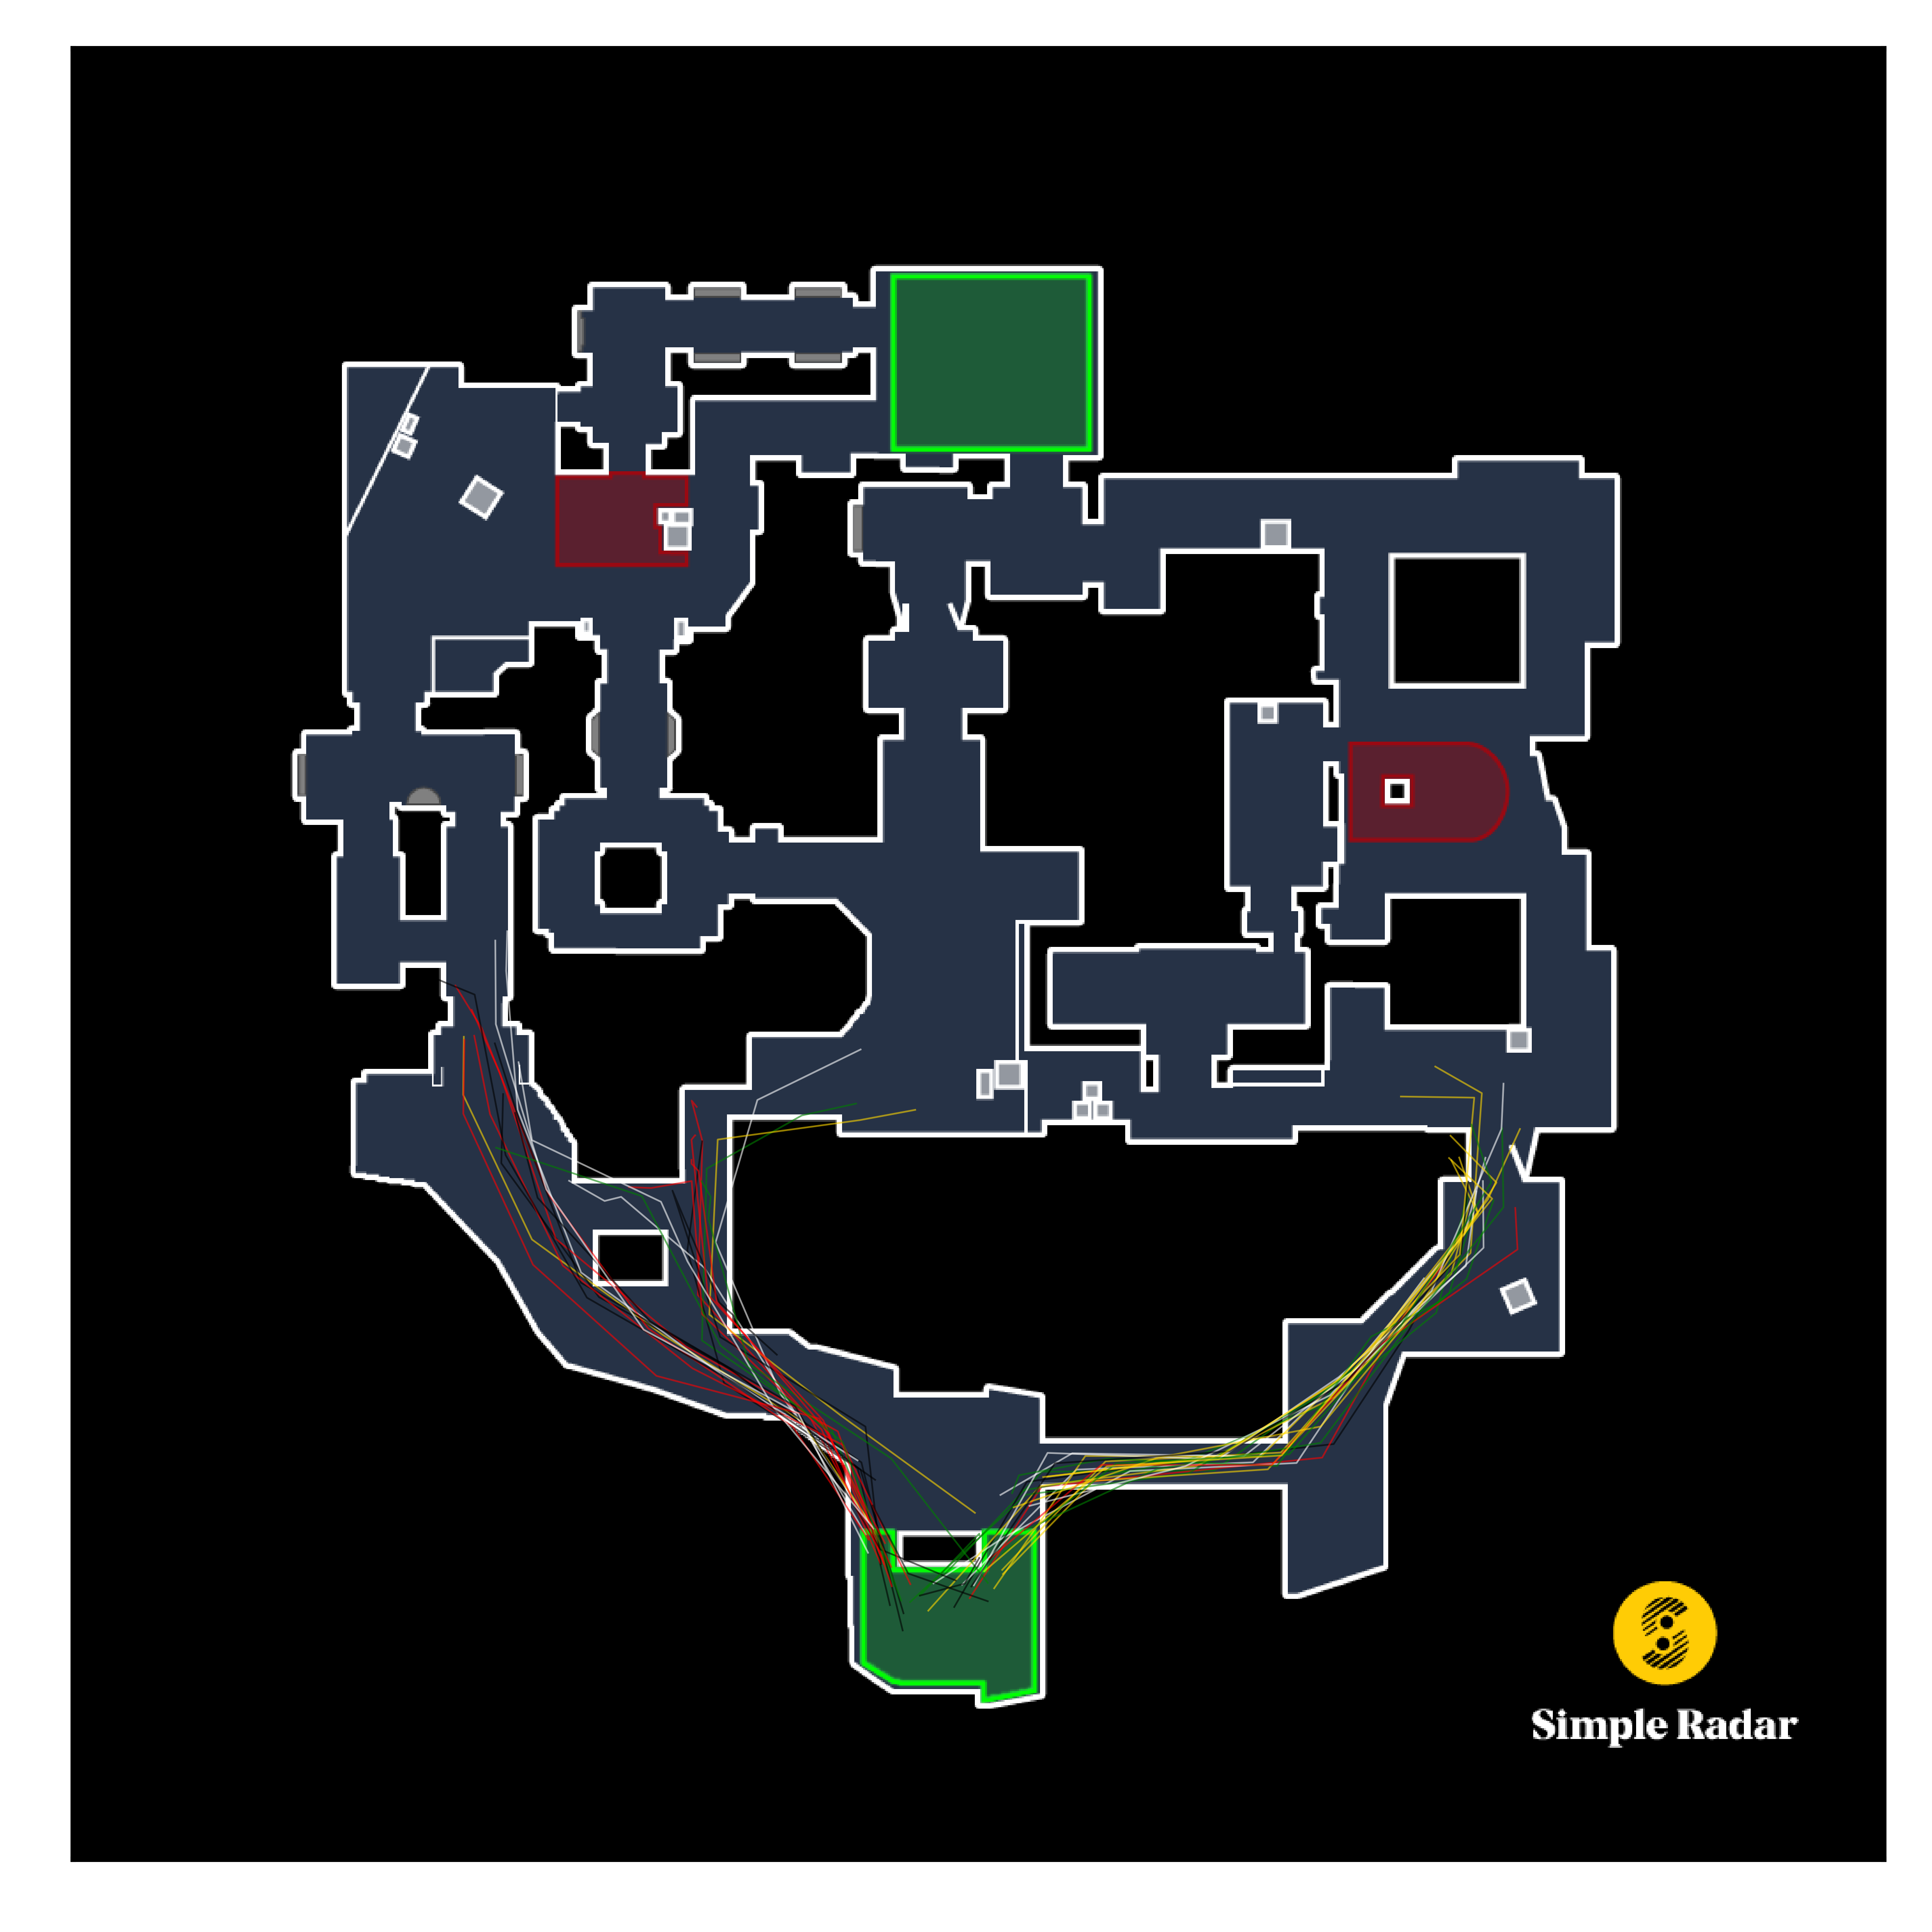

In [24]:
Image(filename='ALL_trajectories_de_ancient_T_10_False_area_10_123.png') 

Here every line represents a players trajectory in one round.
Each round has one trajectory of each color of red,white,green,yellow and black.
So every red line is from a different round. Colors are assigned to a players trajectory in such a way that players across rounds that have similar trajectories get the same color. For example if in round X and round Z only one players goes to B then those two players will have the same color.

We see that we have almost all yellow lines go towards B. This means that in almost every round at least one player went there.
However the red, green and white lines are a bit more of a mess.
So lets look at the clustering results.

Lets start with k-meds. Here we set the number of clusters to 3. So this is what we will get.

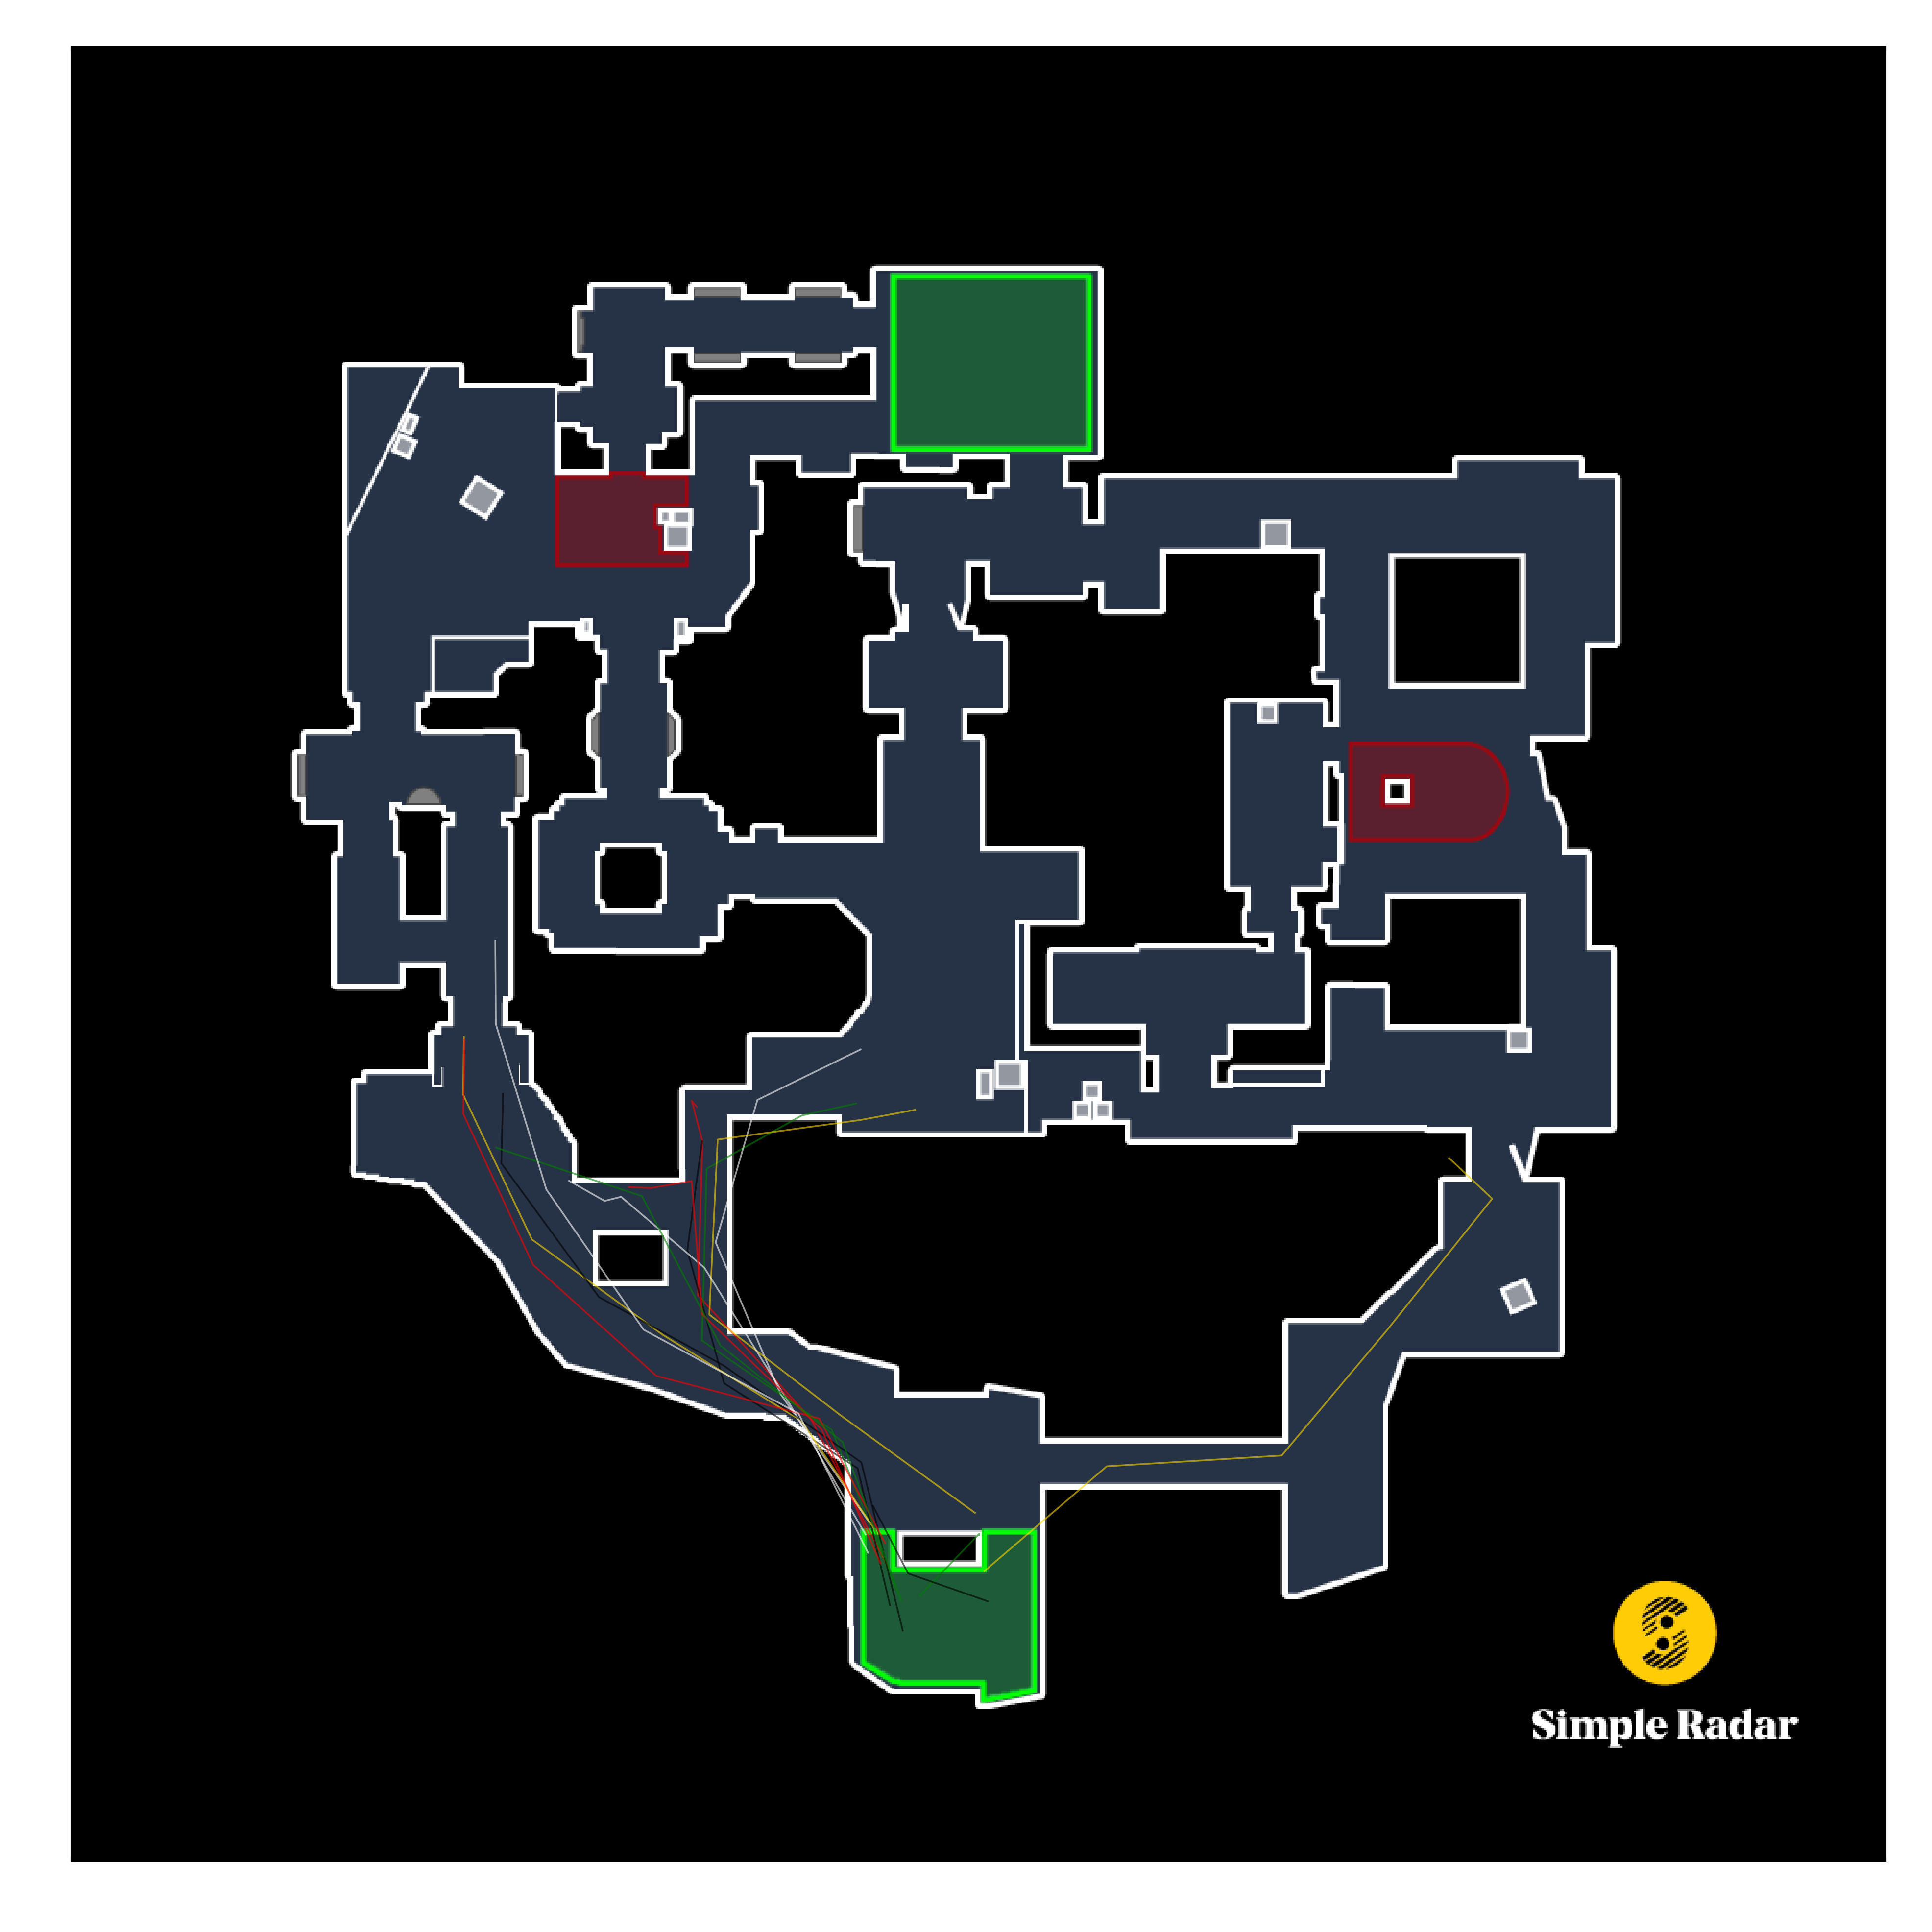

In [25]:
Image(filename='kmed_3_0_de_ancient_T_10_False_area_10_123.png') 

The above picture is the first cluster as returned by k-meds.
We see that most trajectories have purely players going towards mid/A.
However there seems to be one round that slipped in with someone going towards B.

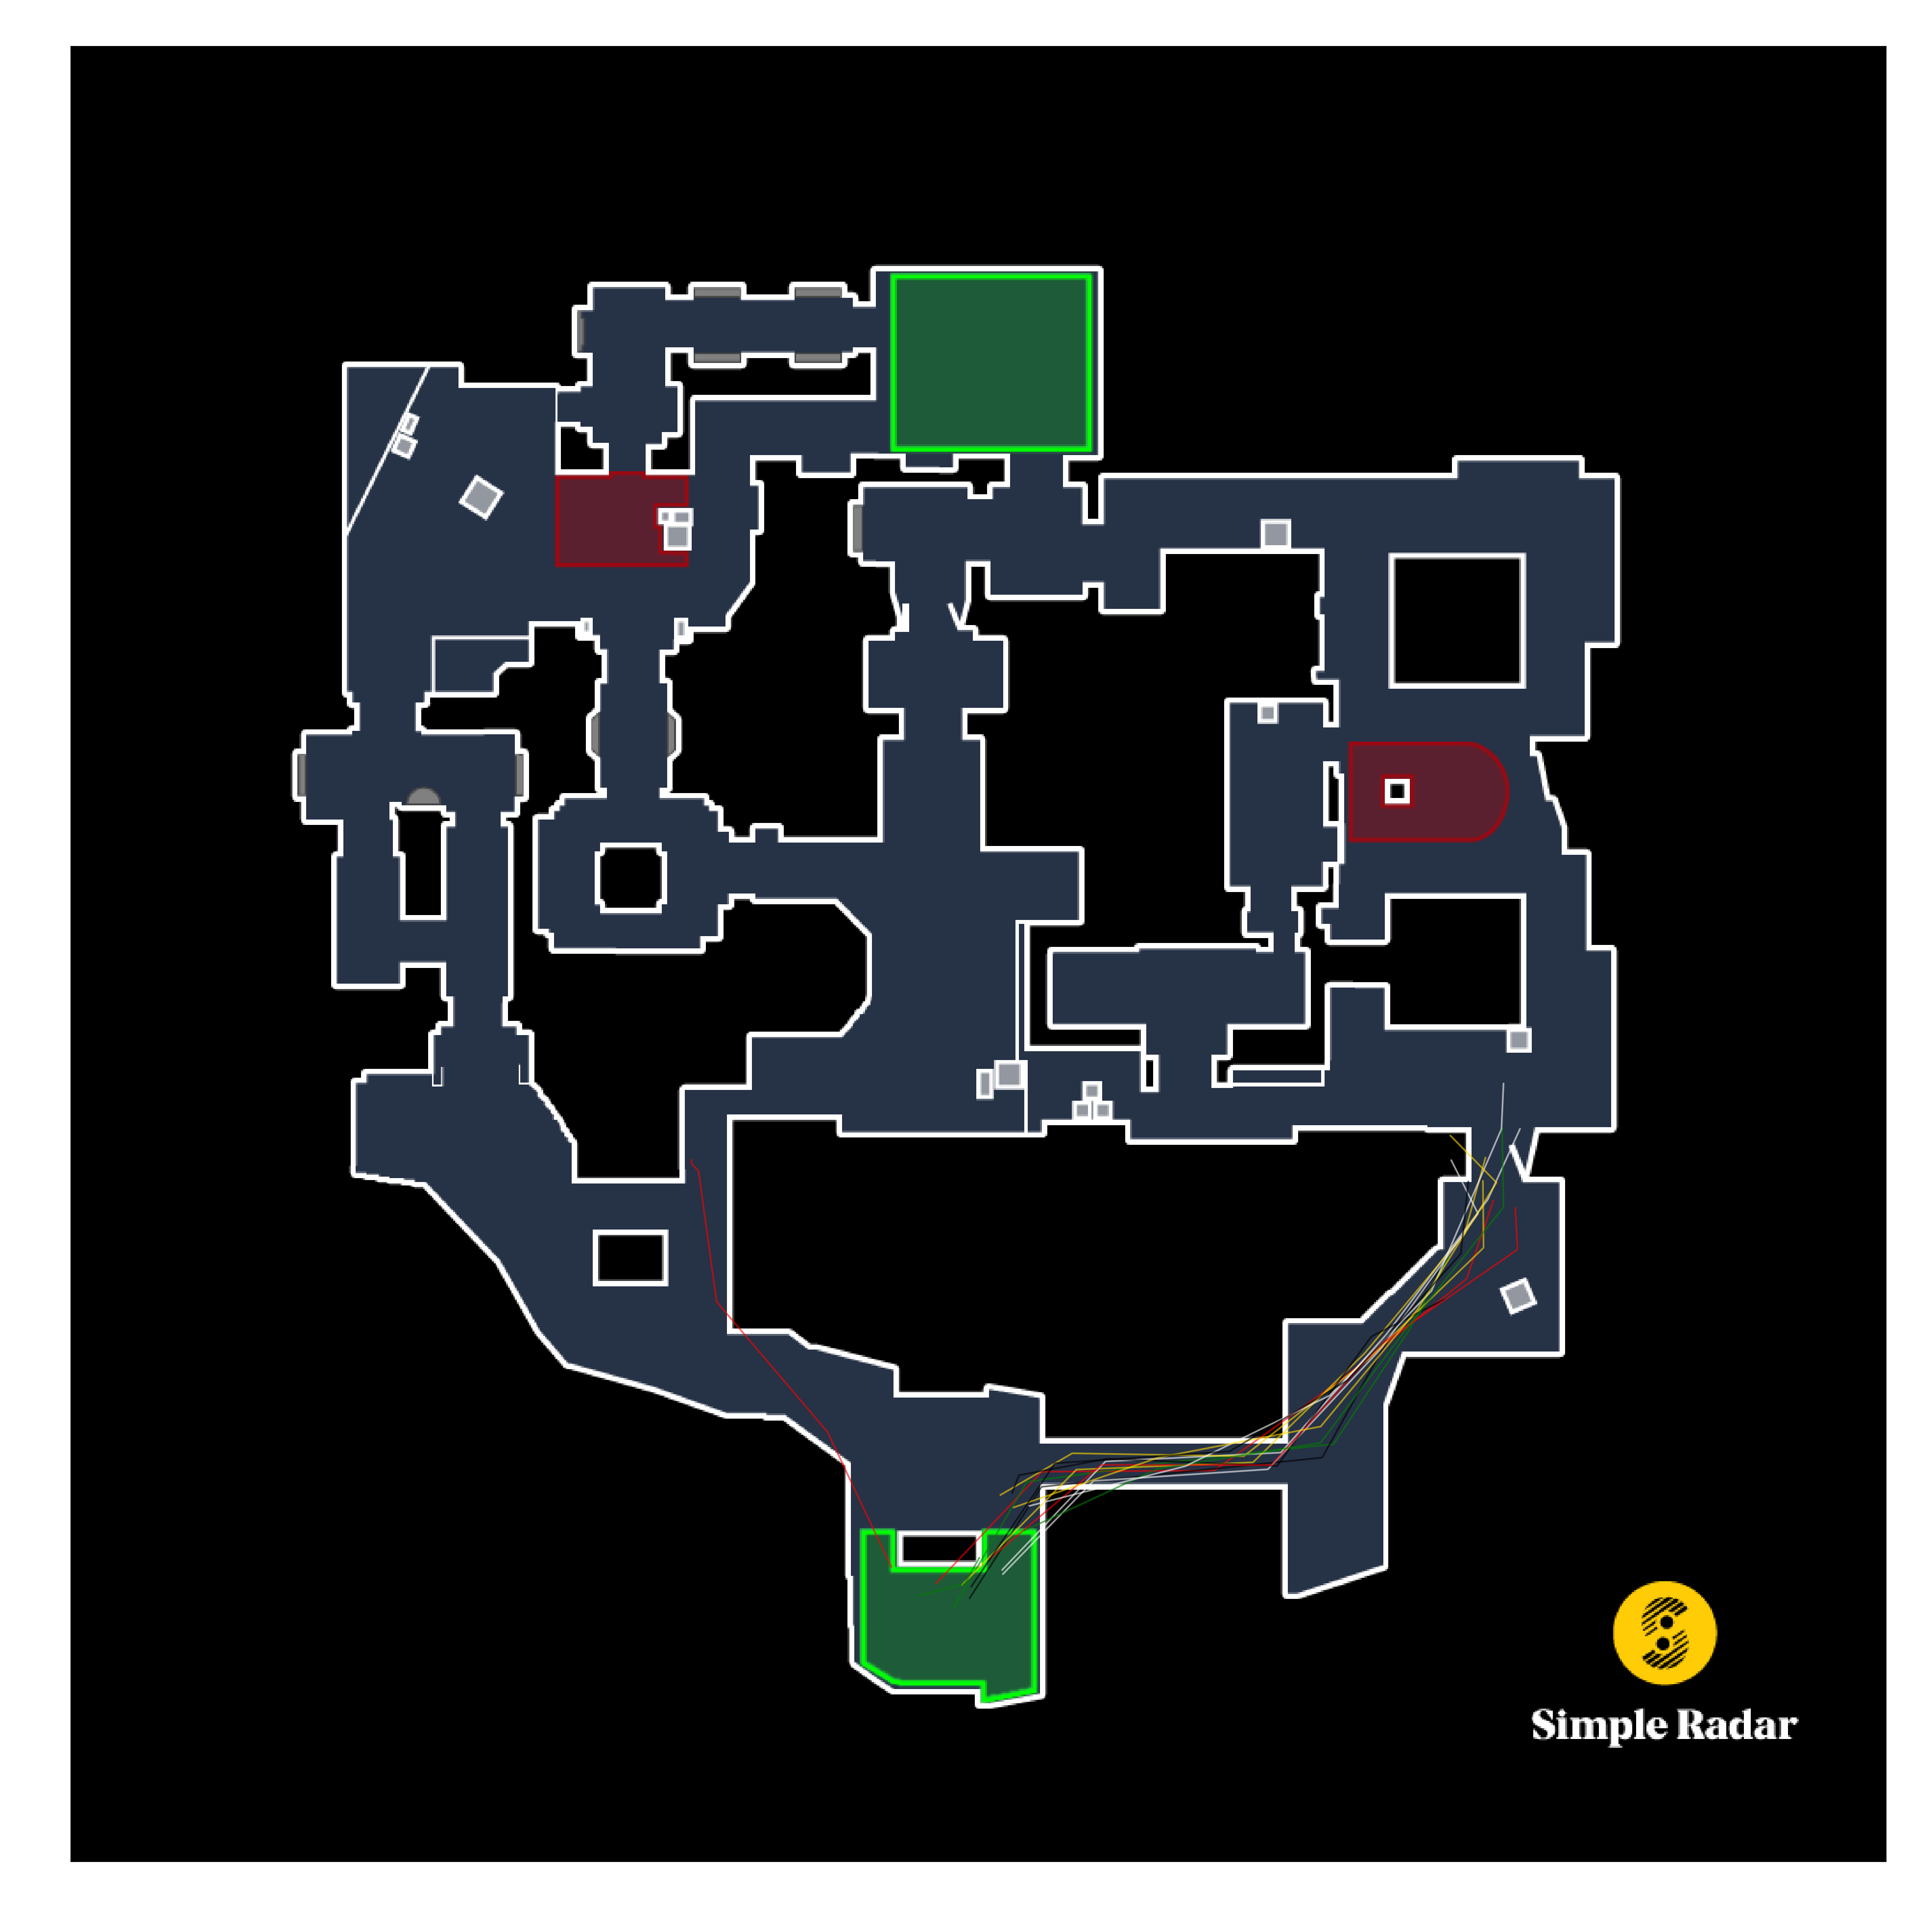

In [26]:
Image(filename='kmed_3_1_de_ancient_T_10_False_area_10_123.png') 

The behaviour for the second cluster is similar to that of the first.
In almost all of the rounds all 5 players are moving towards B. There is just one round where only 4 players went B and one went towards mid.

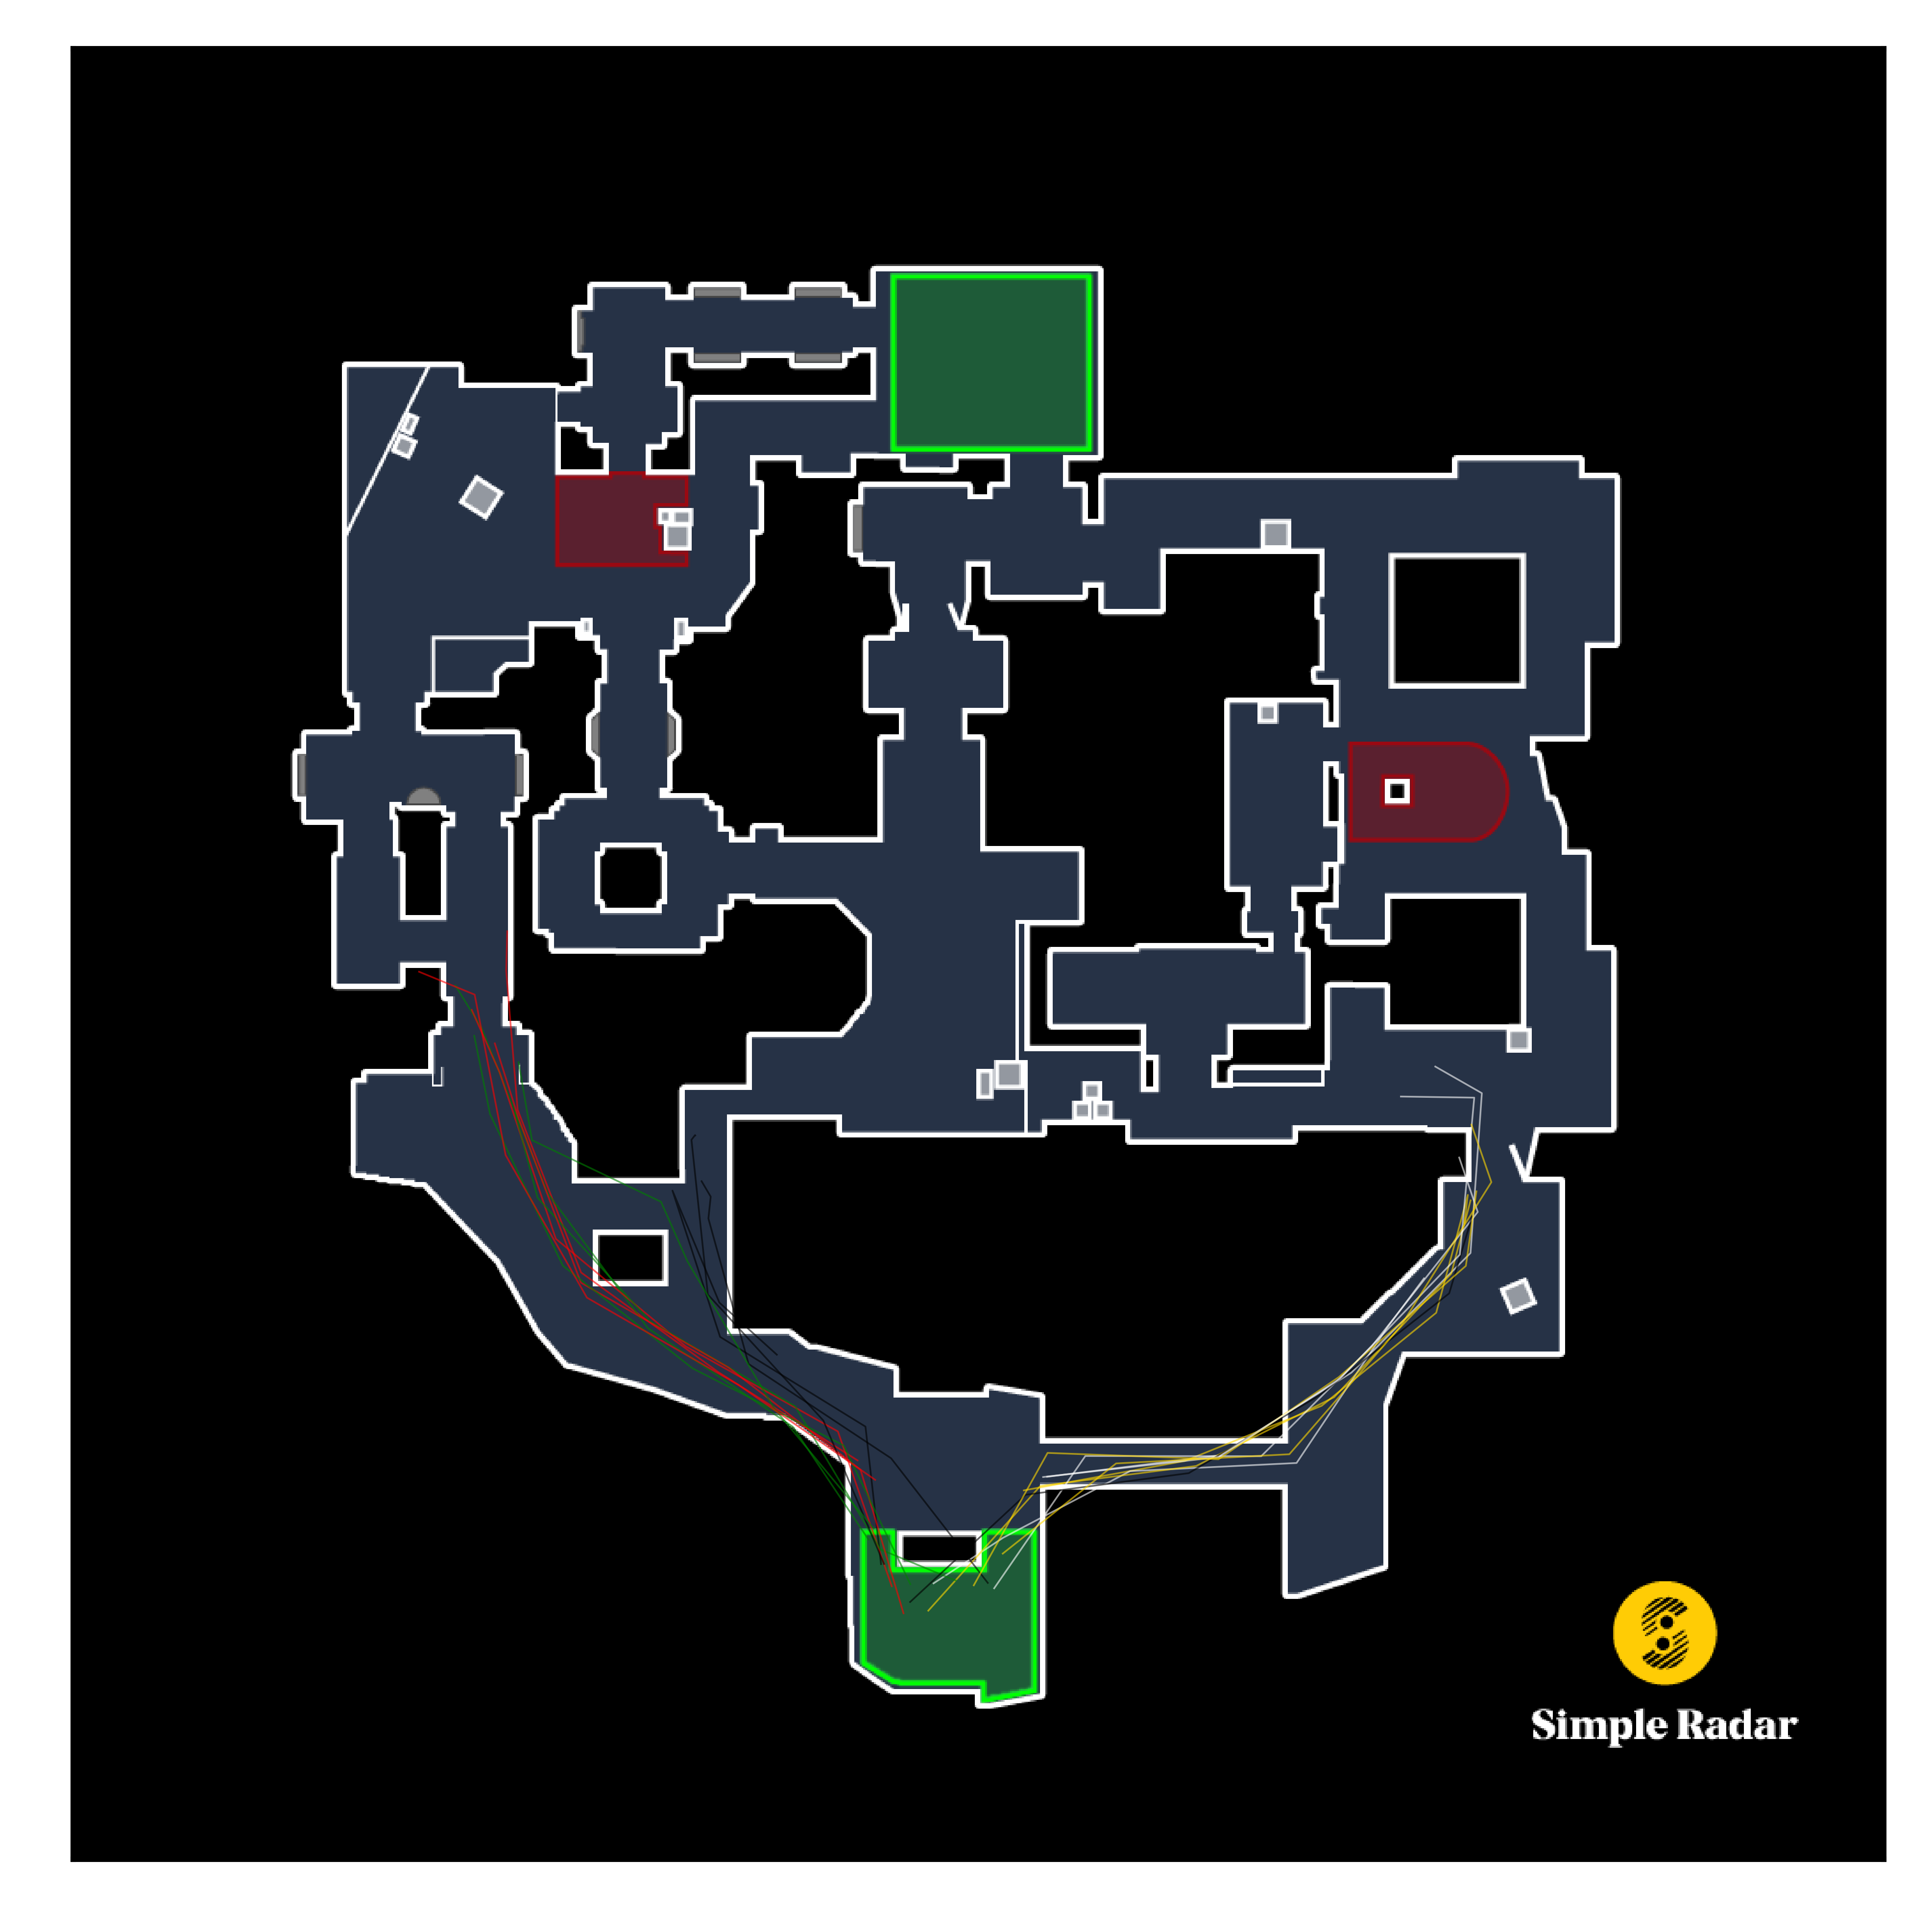

In [27]:
Image(filename='kmed_3_2_de_ancient_T_10_False_area_10_123.png') 

The last cluster is a bit more diverse with generally having two people towards B and the rest going towards mid and A.
If we allow for more clusters (and use more rounds) we could probably get even finer separation here.

Lastly lets have a look at the result from the dbscan algorithm.
DBscan gave us two clusters and a group of outlier trajectories that it could not assign to any cluster.

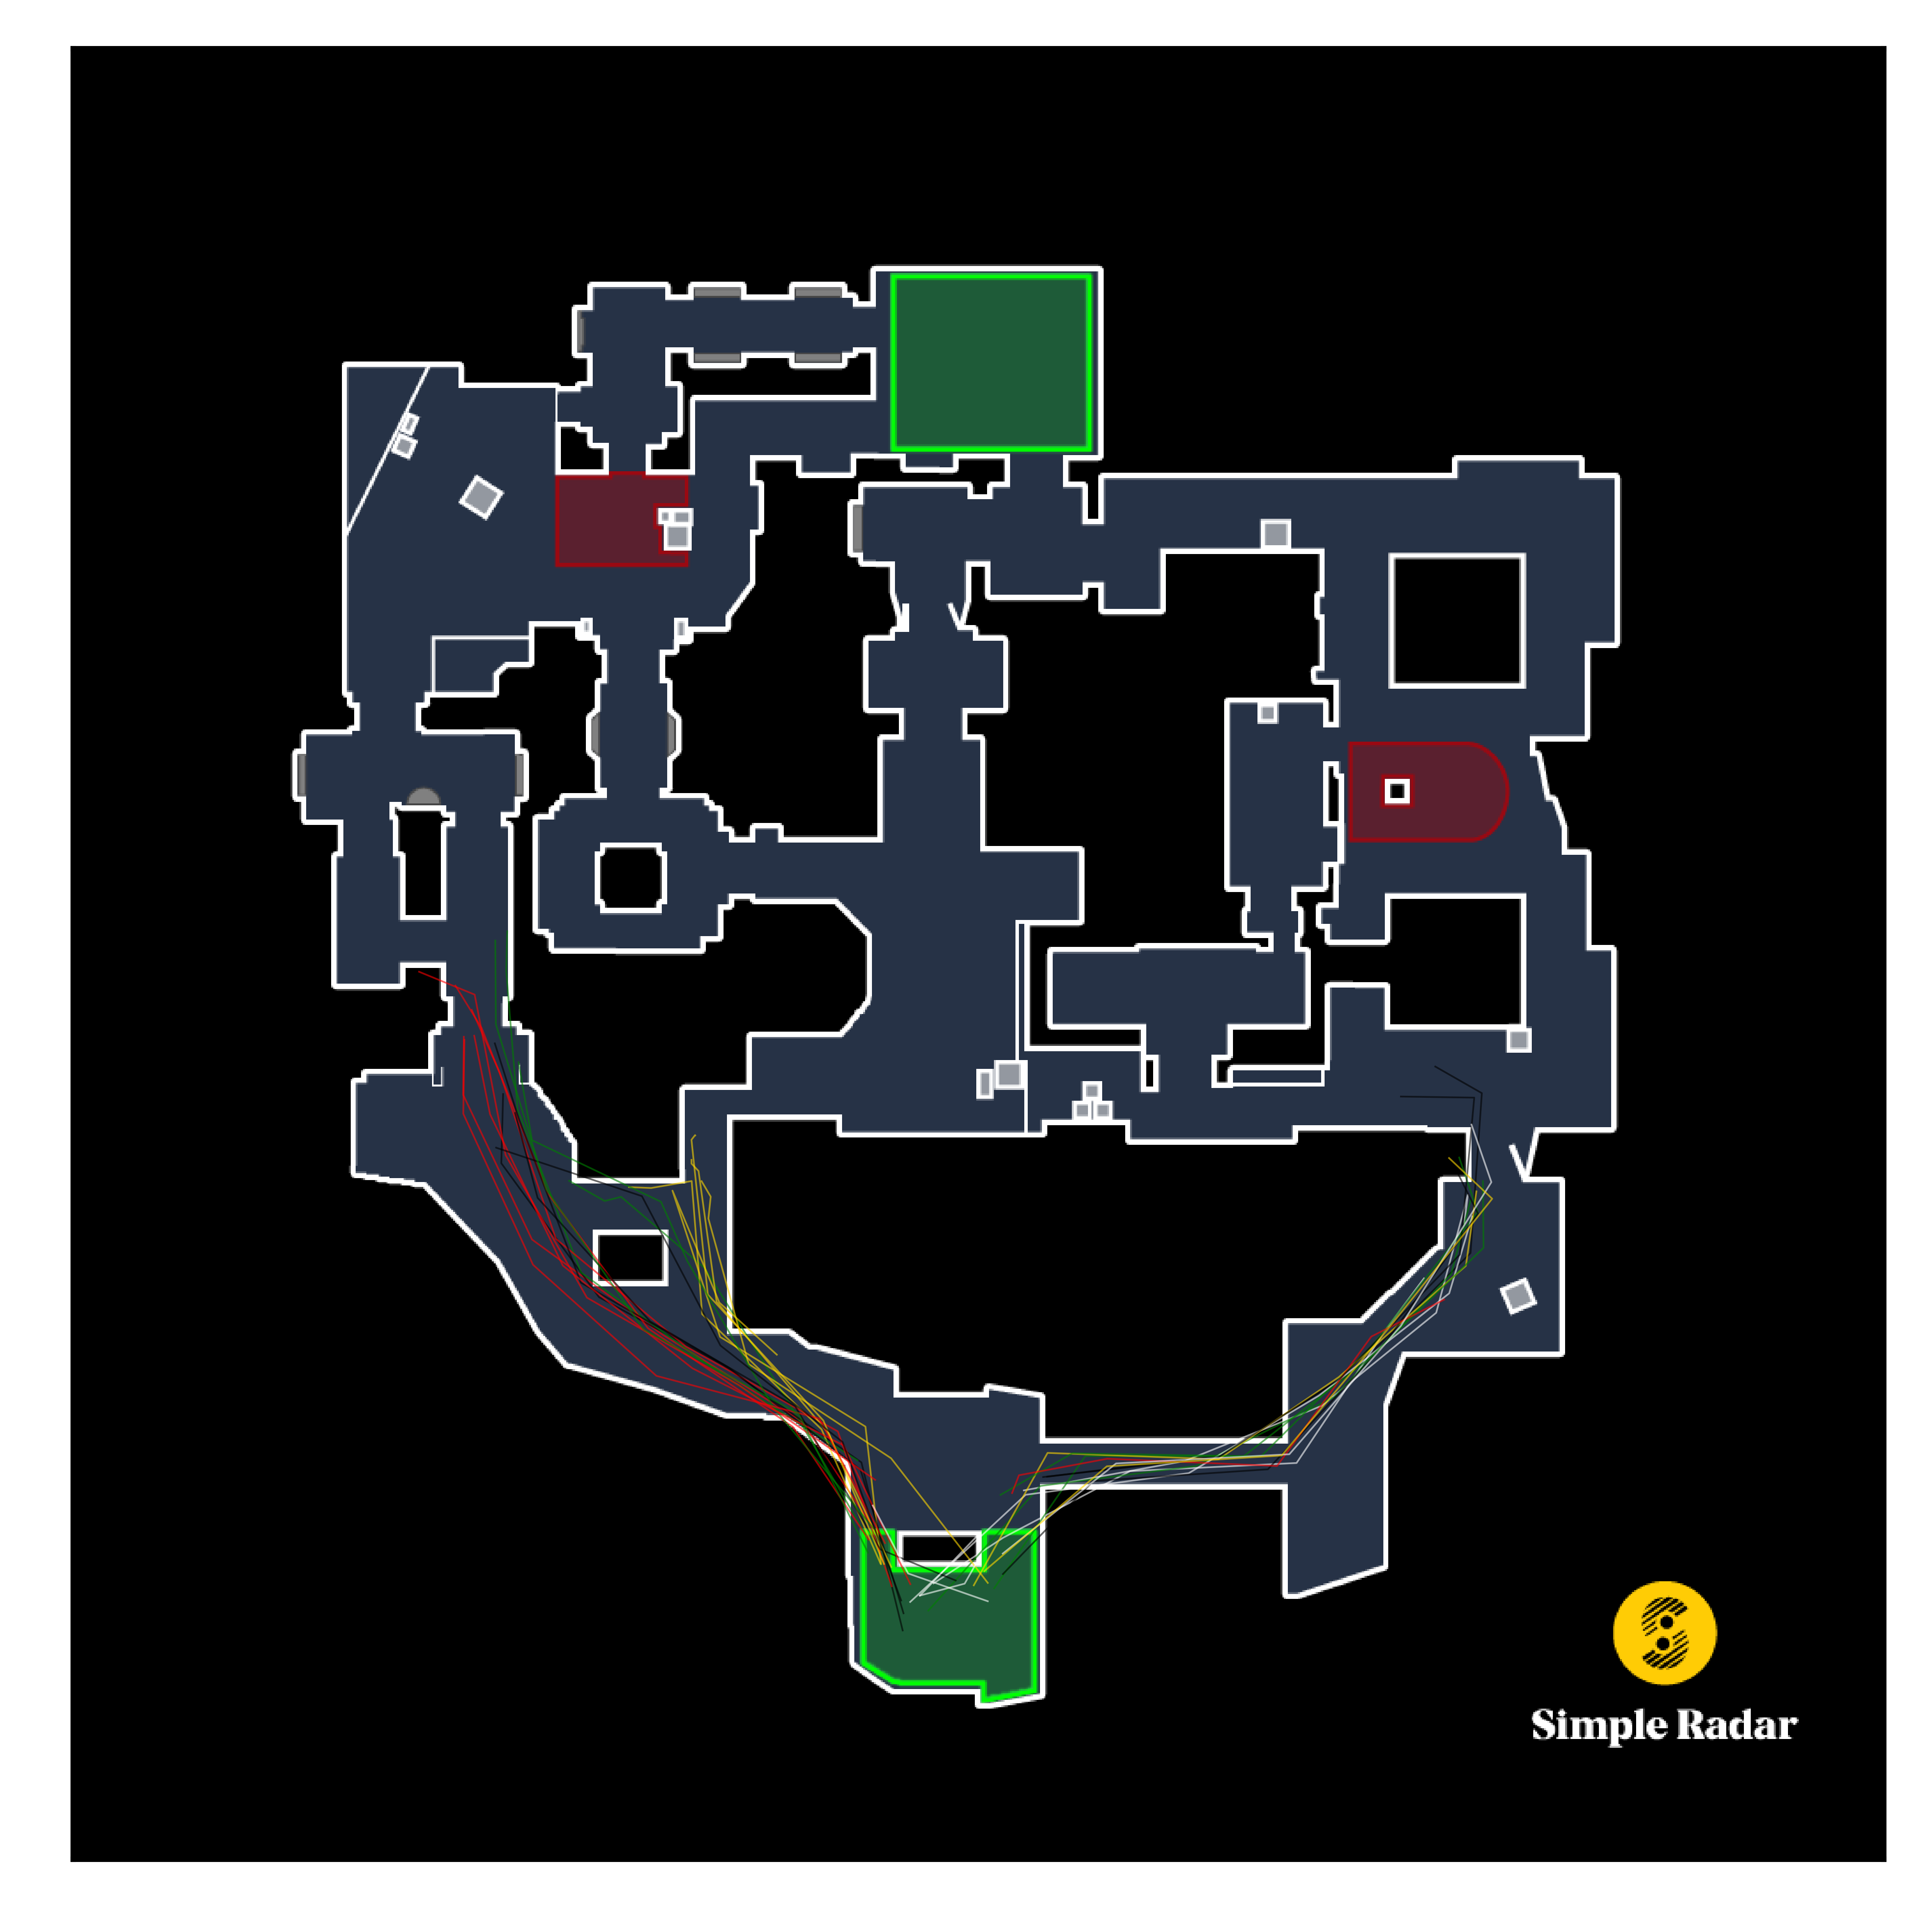

In [28]:
Image(filename='dbscan_2_500_0_de_ancient_T_10_False_area_10_123.png') 

The first cluster is similar to the third cluster from k-meds, but it seems that dbscan has also thrown in some rounds that k-meds put into its first cluster.

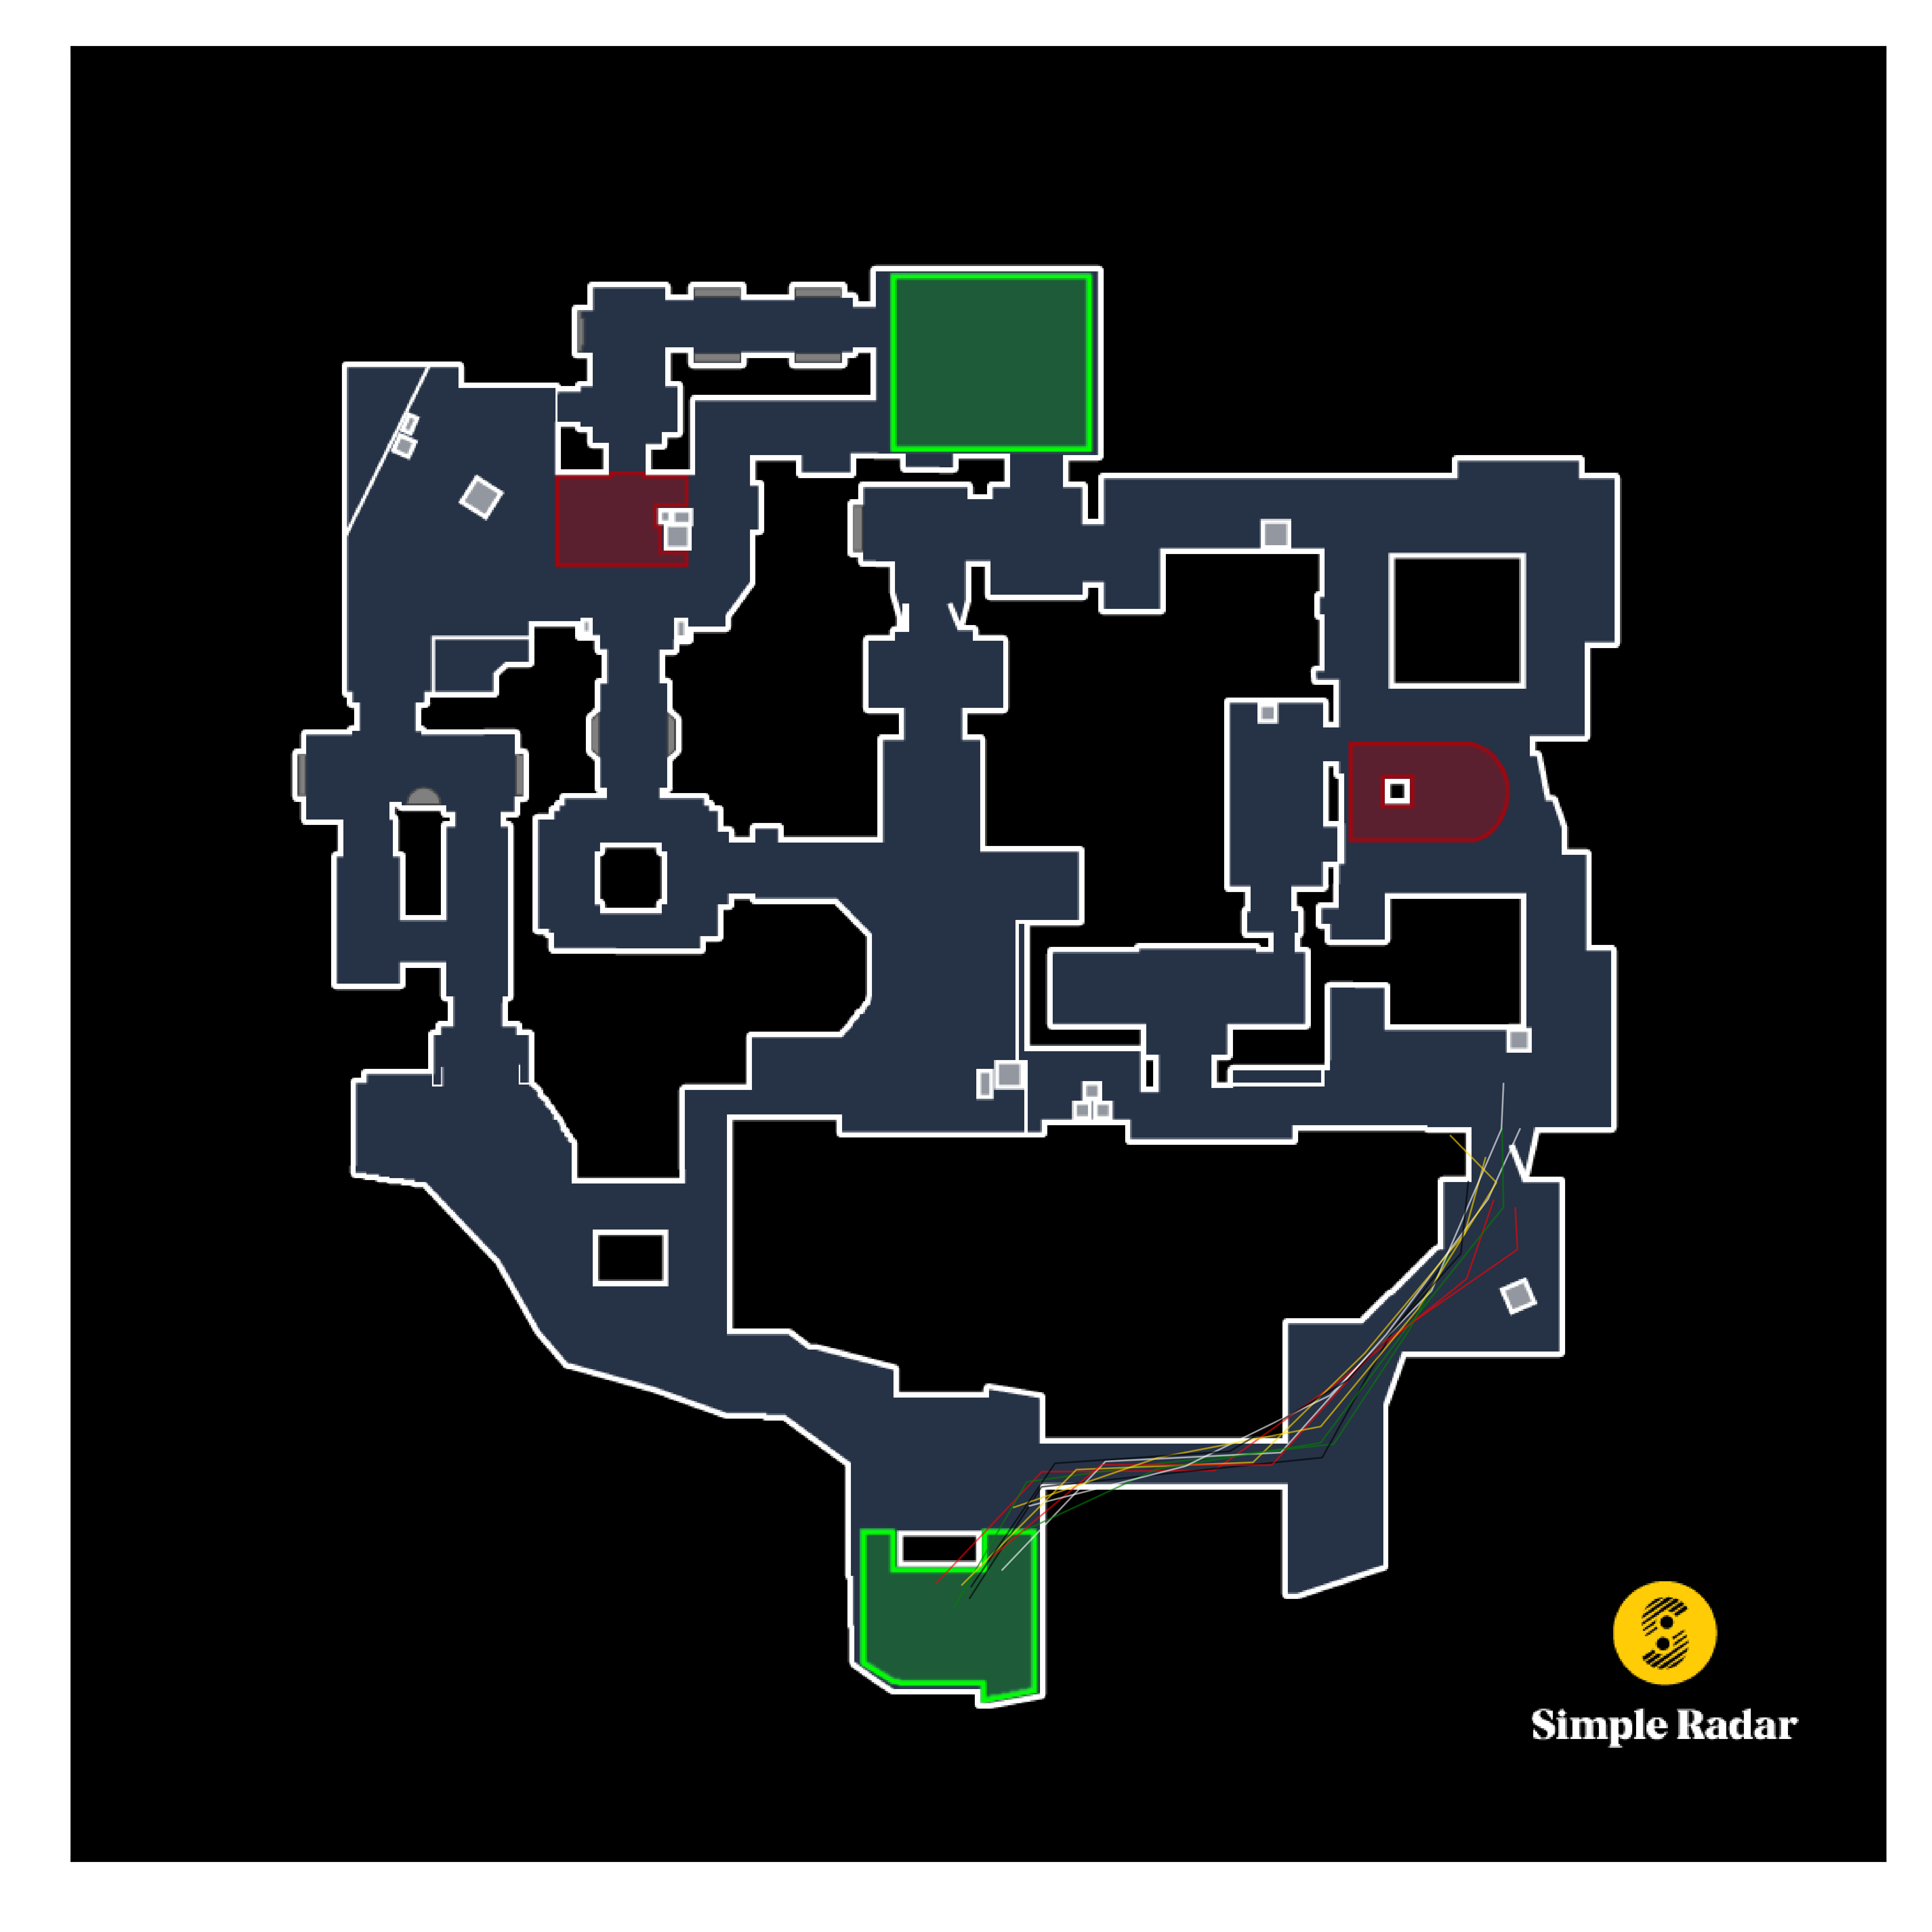

In [29]:
Image(filename='dbscan_2_500_1_de_ancient_T_10_False_area_10_123.png') 

The second cluster is similar to the second one from k-meds. However dbscan has excluded the one round where only 4 players went B. Both clusters here seem to be a bit cleaner than the ones from k-meds.

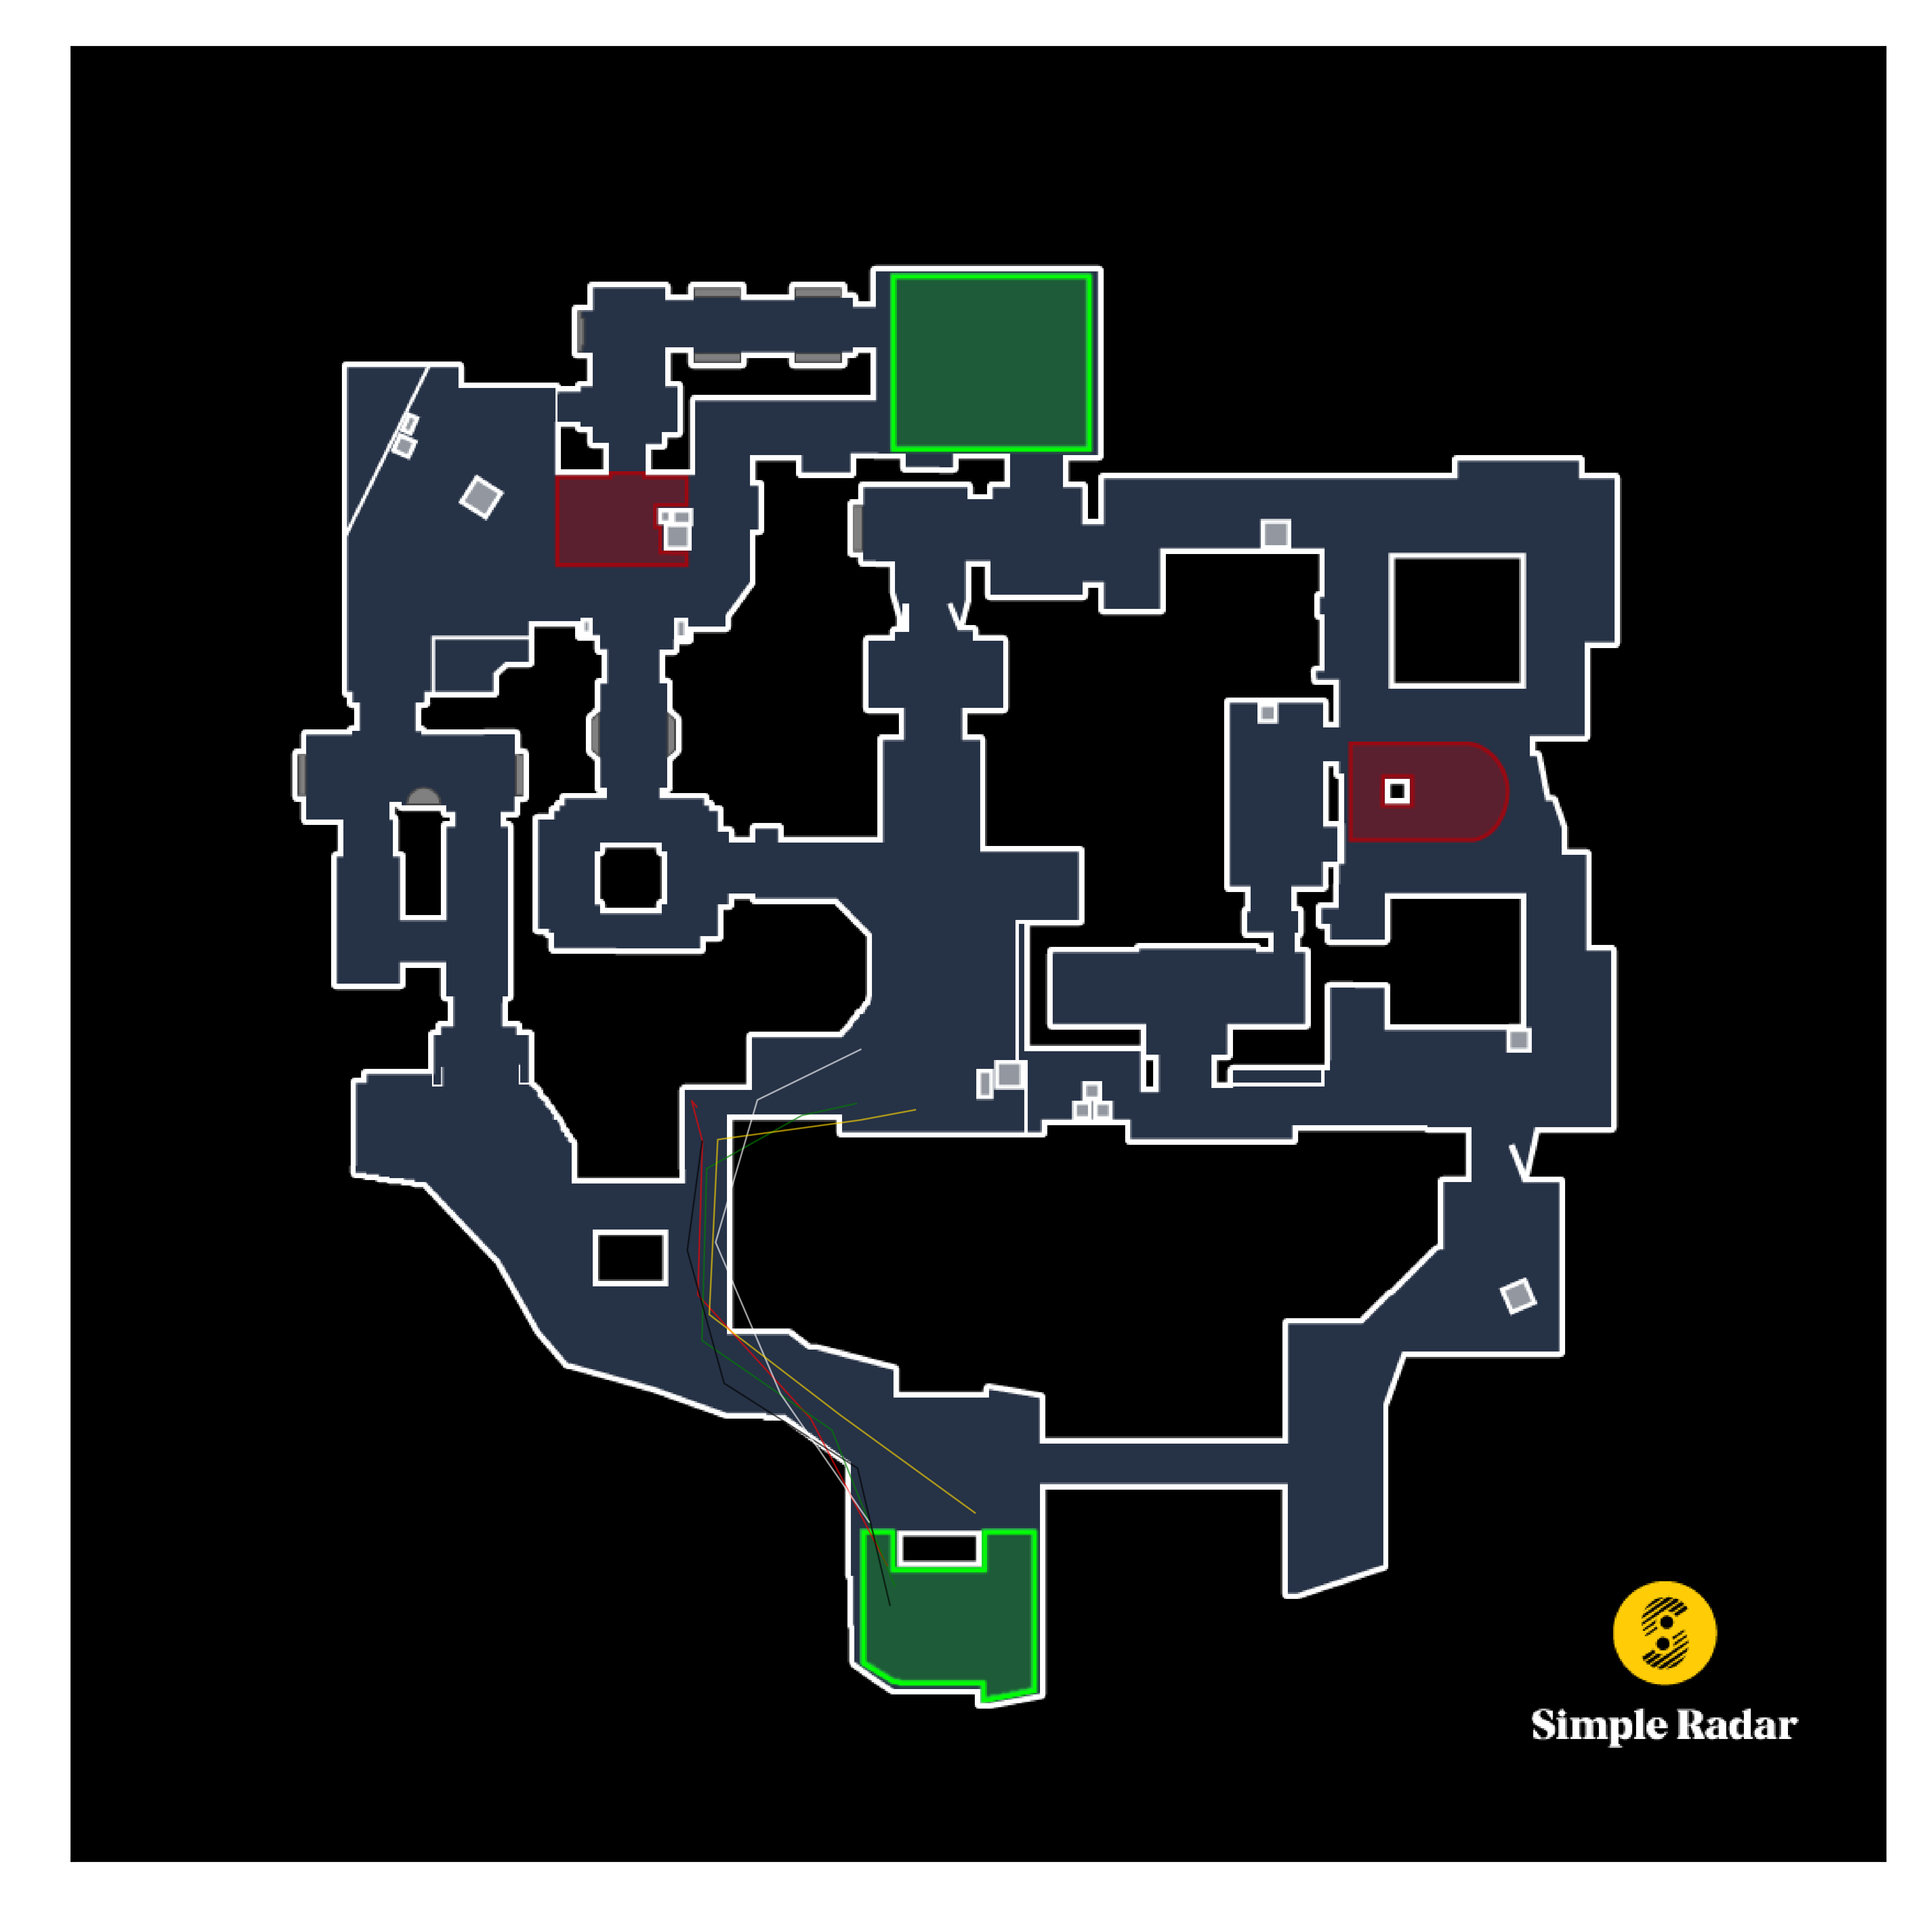

In [30]:
Image(filename='dbscan_2_500_-1_de_ancient_T_10_False_area_10_123.png') 

Here is the one round that it could not assign to any cluster. However with more rounds to consider this round might start a cluster of rounds with heavy mid focus/mid rushes and we would end up with 3 clean clusters from dbscan.